# Installs

### Select Mlaas Kernel

In [1]:
!pip install numpy pandas matplotlib mlflow==1.26.1 boto3 kubernetes scikit-image scikit-learn tqdm

     |████████████████████████████████| 11.8 MB 23.4 MB/s            
     |████████████████████████████████| 17.8 MB 84.2 MB/s            
     |████████████████████████████████| 14.0 MB 52.2 MB/s                                | 327 kB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 68.9 MB/s            
     |████████████████████████████████| 34.4 MB 69.3 MB/s            ███████████████████▏     | 28.2 MB 69.3 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 72.9 MB/s            
     |████████████████████████████████| 299 kB 73.2 MB/s            
     |████████████████████████████████| 3.4 MB 71.5 MB/s            
     |████████████████████████████████| 1.6 MB 65.5 MB/s            
     |████████████████████████████████| 3.4 MB 67.9 MB/s            
     |████████████████████████████████| 2.0 MB 61.3 MB/s            
     |████████████████████████████████| 6.9 MB 74.5 MB/s            
     |████████████████████████████████| 210 kB 69.6 MB/s      

In [2]:
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     |████████████████████████████████| 1977.9 MB 318 bytes/s                        | 34.9 MB 4.2 MB/s eta 0:07:45|█▏                              | 71.8 MB 91.2 MB/s eta 0:00:21 MB 57.5 MB/s eta 0:00:334327                      | 206.3 MB 68.7 MB/s eta 0:00:26 MB 5.0 MB/s eta 0:05:46  MB 5.0 MB/s eta 0:05:44  eta 0:05:43  MB 5.0 MB/s eta 0:05:42                   | 287.8 MB 5.0 MB/s eta 0:05:41  MB 5.0 MB/s eta 0:05:40  MB 5.0 MB/s eta 0:05:40  MB 13.5 MB/s eta 0:02:04 MB 13.5 MB/s eta 0:02:04��████▍                          | 333.6 MB 13.5 MB/s eta 0:02:02��████▍                          | 335.8 MB 13.5 MB/s eta 0:02:02��████▌                          | 337.8 MB 13.5 MB/s eta 0:02:02        | 421.5 MB 1.3 MB/s eta 0:19:58                 | 508.2 MB 38.2 MB/s eta 0:00:393 0:22              | 646.1 MB 909 kB/s eta 0:24:24           | 675.7 MB 909 kB/s eta 0:23:52              | 689.5 MB 30.5 MB/s eta 0

# Imports

In [3]:

import sys
import numpy as np
import pandas as pd
import gc
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime


In [4]:
import mlflow
import json
import os
from kubernetes import client, config

In [5]:
import colorsys
import random
from skimage.measure import find_contours
from matplotlib.patches import Polygon

# Env Variables

In [6]:
MINIO_ACCESS_KEY_ID = 'hvsahibi01'
MINIO_SECRET_ACCESS_KEY = 'd2ifgySTz/UTZ4Me+L1do/jso8gyyFigCc41vbdoEoP09nqNXrfcXUENTQOAG3c32hEAabIeZWoVc0KaCI45Cw=='
MINIO_MLFLOW_ENDPOINT = 'http://minio.minio.svc.cluster.local:9000/'
NAMESPACE = 'hitachi-solutions'

os.environ['MLFLOW_TRACKING_URI'] = f'http://lumada-ml-model-lifecycle-mlflow.{NAMESPACE}.svc.cluster.local:5000'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = MINIO_MLFLOW_ENDPOINT
os.environ['AWS_ACCESS_KEY_ID'] = MINIO_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = MINIO_SECRET_ACCESS_KEY

In [149]:
files_root_path="shared/devs/mramos/Hackathon" 
conda_env = os.path.join(files_root_path, "pytorch-env.yaml")
model_file=f"model_1.bin"
experiment_name="hackathonv2"

# Log Model to MLflow

In [150]:
from mlflow import pyfunc as mlflow_pyfunc

def model_pack_register(path,
                        experiment_name,
                        run_id=None,
                        namespace=NAMESPACE,
                        minio_endpoint=MINIO_MLFLOW_ENDPOINT,
                        minio_access_id=MINIO_ACCESS_KEY_ID,
                        minio_access_key=MINIO_SECRET_ACCESS_KEY):
    """
    if you want to log the model in a new run, leave the run_id to None, otherwise it will replace the artifacts in the run id specified
    """

    
    # MinIO
    os.environ['MLFLOW_TRACKING_URI'] = f'http://lumada-ml-model-lifecycle-mlflow.{namespace}.svc.cluster.local:5000'
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = minio_endpoint
    os.environ['AWS_ACCESS_KEY_ID'] = minio_access_id
    os.environ['AWS_SECRET_ACCESS_KEY'] = minio_access_key
    


        
    
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_id):
        
        # THIS CALL ALONE WOULD CREATE A NEW RUN. WE WANT THE SAME RUN WE TRAINED THE MODEL IN, HENCE THE run_id PARAM IN THE mlflow.start_run() CALL.
        mlflow_pyfunc.log_model(artifact_path='model', 
                                loader_module='module_executer', 
                                data_path=os.path.join(path, model_file), 
                                conda_env=conda_env, 
                                code_path=[os.path.join(path, 'module_executer.py')])
        


model_pack_register(files_root_path, experiment_name, run_id=None)

2023/01/16 17:19:41 INFO mlflow.tracking.fluent: Experiment with name 'hackathonv2' does not exist. Creating a new experiment.


# Deploy Model using Seldon

In [151]:
experiment_id=dict(mlflow.get_experiment_by_name(experiment_name))['experiment_id']
df = mlflow.search_runs([experiment_id])
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.source.type
0,d337c156b01c4bea8dfe376db43102fb,10,FINISHED,s3://mlruns-hibi-04/10/d337c156b01c4bea8dfe376...,2023-01-16 17:19:41.765000+00:00,2023-01-16 17:19:42.873000+00:00,jovyan,/usr/local/bin/kernel-launchers/python/scripts...,"[{""run_id"": ""d337c156b01c4bea8dfe376db43102fb""...",LOCAL


In [154]:
artifact_location = df[(df["status"]=="FINISHED") & (df["tags.mlflow.log-model.history"]!="None")].iloc[0]["artifact_uri"]+"/model"
print("Artifact location:", artifact_location)

Artifact location: s3://mlruns-hibi-04/10/d337c156b01c4bea8dfe376db43102fb/artifacts/model


In [155]:
config.load_incluster_config()

core_api_client = client.CoreV1Api()

custom_objs_api_client = client.CustomObjectsApi()

In [156]:
MODEL_NAME = 'hackathon'

In [157]:
# with open('shared/devs/mramos/rusty_v2/rusty_deployment_template.json') as json_file:
#     sdep = json.load(json_file)
#     print(sdep)

In [158]:
sdep = {
   "apiVersion": "machinelearning.seldon.io/v1",
   "kind": "SeldonDeployment",
   "metadata": {
      "name": MODEL_NAME
   },
   "spec": {
      "name": MODEL_NAME,
      "annotations": {
        "sidecar.istio.io/inject": "false"
      },
      "predictors": [
         {
            "componentSpecs": [
               {
                  "spec": {               

                     "containers": [
                        {
                           "name": "classifier",
                           "resources": {
                                "limits": {
                                  "cpu": "1",
                                  "memory": "7Gi",
                                  "nvidia.com/gpu": '1'
                                },
                                "requests": {
                                  "cpu": "1",
                                  "memory": "6Gi",
                                  "nvidia.com/gpu": '1'
                                }
                              },
                           "livenessProbe": {
                              "initialDelaySeconds": 80,
                              "failureThreshold": 200,
                              "periodSeconds": 5,
                              "successThreshold": 1,
                              "httpGet": {
                                 "path": "/health/ping",
                                 "port": "http",
                                 "scheme": "HTTP"
                              }
                           },
                           "readinessProbe": {
                              "initialDelaySeconds": 80,
                              "failureThreshold": 200,
                              "periodSeconds": 5,
                              "successThreshold": 1,
                              "httpGet": {
                                 "path": "/health/ping",
                                 "port": "http",
                                 "scheme": "HTTP"
                              }
                           }
                        }
                     ],
                "tolerations":[{
                    "effect": "NoSchedule",
                    "key": "workload",
                    "operator": "Equal",
                    "value": "inference",      
                    }]
                  }
               }
            ],
            "graph": {
               "children": [],
               "implementation": "MLFLOW_SERVER",
               "modelUri": artifact_location,
               "name": "classifier",
            },
            "name": "default",
            "replicas": 1,
            "svcOrchSpec":{
              "resources": {
                "requests": {
                  "cpu": "1",
                  "memory": "3Gi",
                }
              },
                 
            }
         }
      ]
   }
}

In [159]:
# with open('shared/devs/mramos/rusty_v2/rusty_deployment_template.json', 'w') as outfile:
#     json.dump(sdep, outfile)

In [160]:
print("Deploying model '%s'..." % (MODEL_NAME))

try:
    res = custom_objs_api_client.create_namespaced_custom_object(group='machinelearning.seldon.io', version='v1', plural='seldondeployments', namespace=NAMESPACE, body=sdep)
except Exception as ex:
    print(ex.status, ex.reason)
else:
    print('Done.')

Deploying model 'hackathon'...
Done.


We have to wait for the pod to initialize so run the cell below to check it's status or check on lens, and only test inference after the status is:       Running		2/2		rusty-model-default...

In [14]:
def get_container_statuses(obj):
    total = len(obj.status.container_statuses)
    ready = 0
    
    for c in obj.status.container_statuses:
        if c.ready:
            ready = ready + 1
            
    return (ready, total)

print(f'Searching the "{NAMESPACE}" namespace...\n')

res = core_api_client.list_namespaced_pod(namespace=NAMESPACE, label_selector=f'seldon-deployment-id={MODEL_NAME}')

for i in res.items:
    ready, total = get_container_statuses(i)
    print('Status\t\tReady\t\tName')
    print('------\t\t-----\t\t----')
    print("%s\t\t%s/%s\t\t%s" % (i.status.phase, ready, total, i.metadata.name))

Searching the "hitachi-solutions" namespace...

Status		Ready		Name
------		-----		----
Running		2/2		hackathon-default-0-classifier-7d4d7f4f8d-q5wzk


# Test Inference Pods

In [144]:
sound_file=[]
with open('shared/devs/mramos/Hackathon/sound_file3.txt','r') as f:
    for line in f:
        sound_file.append(float(line))


In [145]:
#data = {'jsonData':{'image':sound_file}}


data = {
  "data":{
    "tensor":{
      "shape": np.array(sound_file).shape,
        "values": sound_file
    }
  }
}

In [146]:
np.array(sound_file).shape

(84096,)

In [147]:
out_file = open("shared/devs/mramos/Hackathon/sound_file3.json", "w")
json.dump(data, out_file)

In [120]:
import requests
import time

# Predict
def predict(new_data, thread):
    #print(f'starting thread # {thread}')
    start_time = time.time()
    predictor_name = sdep['spec']['predictors'][0]['name']
    
    headers = {
            'Content-Type': 'application/json'
    }

    try:
        response = requests.post(f'https://hibi-dev.hitachi-lumada.io/seldon/hitachi-solutions/hackathon/api/v1.0/predictions', json=new_data, headers=headers)
        #response = requests.post(f'http://{MODEL_NAME}-{predictor_name}.{NAMESPACE}.svc.cluster.local:8000/api/v1.0/predictions', json=new_data, headers=headers)
        response.raise_for_status()
        print(time.time() - start_time)
        #print(f'ending thread # {thread}')
        return response.json()
    except requests.HTTPError as http_err:
        print('Error on predict! HTTPError: %s %s' % (http_err.response.status_code, http_err.response.reason))
    except requests.ConnectionError as conn_err:
        print('Error on predict! ConnectionError: %s' % conn_err)
    except requests.Timeout as t:
        print('Error on predict! Timeout: %s' % t)
    except requests.RequestException as req_ex:
        print('Error on predict! Unknown: %s' % req_ex)
    

In [83]:
predictor_name = sdep['spec']['predictors'][0]['name']
f'http://{MODEL_NAME}-{predictor_name}.{NAMESPACE}.svc.cluster.local:8000/api/v1.0/predictions'

'http://hackathon-default.hitachi-solutions.svc.cluster.local:8000/api/v1.0/predictions'

In [132]:
predict(data, 1)

1.5387294292449951


{'jsonData': {'data': {'class': 'normal', 'score': 0.9988793730735779}},
 'meta': {'requestPath': {'classifier': 'hvacrmlaas01.azurecr.io/seldonio/mlflowserver:1.13.1'}}}

# Multi thread tetsing

In [27]:
import time
# import concurrent.futures

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     executor.map(predict, data)
import threading

threads = list()
for index in range(100):
    
    x = threading.Thread(target=predict, args=(data,index,))
    threads.append(x)
    x.start()

4.455807447433472
7.434585332870483
10.430484771728516
13.451550245285034
16.323028087615967
19.46110987663269
22.438920736312866
25.240777730941772
28.15591287612915
31.281118154525757
33.99612045288086
37.00719118118286
39.919975996017456
42.86251187324524
45.636438846588135
48.692466259002686
51.56315469741821
54.540231704711914
57.36524963378906
60.28702402114868
63.12481737136841
66.08842992782593
69.15176892280579
72.44125628471375
75.37480282783508
78.38797974586487
81.34223818778992
84.21927905082703
87.0707745552063
89.87443685531616
92.57335686683655
95.83562994003296
98.49102997779846
101.74434661865234
104.81947135925293
107.50823664665222
110.96995067596436
113.63518738746643
116.27919697761536
119.25972414016724
122.1923668384552
125.01402235031128
128.3819499015808
131.28835201263428
134.1913239955902
137.01226782798767
139.92502737045288
142.9348292350769
145.783704996109
148.62203335762024
151.9836266040802
154.6838743686676
157.62486028671265
160.85343861579895
163.34

In [20]:
threads

[<Thread(Thread-6, stopped 140586313389824)>,
 <Thread(Thread-7, stopped 140585344313088)>,
 <Thread(Thread-8, stopped 140585335920384)>,
 <Thread(Thread-9, stopped 140585327527680)>,
 <Thread(Thread-10, stopped 140585319134976)>,
 <Thread(Thread-11, stopped 140585310742272)>,
 <Thread(Thread-12, stopped 140585302087424)>,
 <Thread(Thread-13, stopped 140584815687424)>,
 <Thread(Thread-14, stopped 140584807294720)>,
 <Thread(Thread-15, stopped 140584798902016)>]

# Single thread

In [25]:
import time

for _ in range(10):
    start_time = time.time()

    predicted=predict(data, 1)

    #print("--- %s seconds ---" % (time.time() - start_time))
    #print(time.time() - start_time)

5.010747671127319
4.677014589309692
4.55889368057251
4.854046106338501
4.399933576583862
4.625133752822876
4.543992042541504
4.484497308731079
4.5503504276275635
4.845250606536865


In [24]:
print(predicted["jsonData"]['severity'])

[5, 4]


In [27]:
result_image = np.array(predicted["jsonData"]['image']).reshape(json_object["jsonData"]['Shape']).astype(np.uint8)

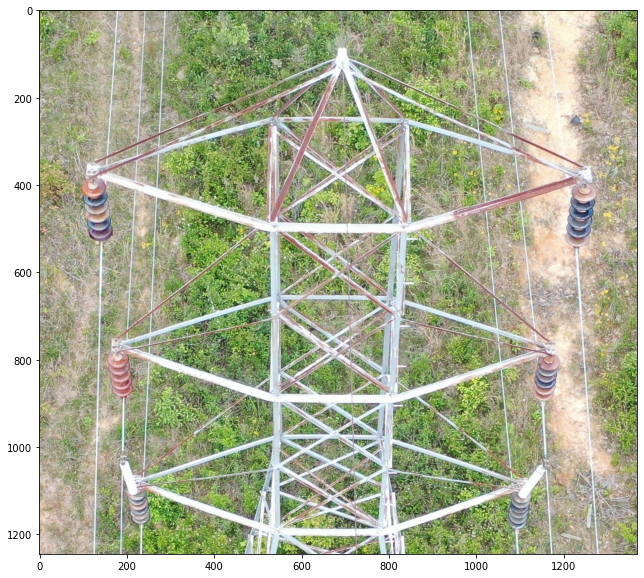

In [28]:
### View original image
_, ax = plt.subplots(figsize=(15, 10))
ax.imshow(result_image)

# Delete deployment

In [153]:
print("Deleting model '%s'..." % (MODEL_NAME))

try:
    
    res = custom_objs_api_client.delete_namespaced_custom_object(group='machinelearning.seldon.io', version='v1', plural='seldondeployments', namespace=NAMESPACE, name=MODEL_NAME)
except client.exceptions.ApiException as ex:
    print('Error on delete! Error: %s %s' % (ex.status, ex.reason))
else:
    print('Done.')

Deleting model 'hackathon'...
Done.
